# Assignment 5: Classification Showdown

Build and compare classification models on the Fashion-MNIST dataset.

## Setup

In [1]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from xgboost import XGBClassifier

from helpers import load_fashion_mnist, plot_roc_curves, plot_confusion_matrix

# Create output directory
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Setup complete!")

Setup complete!


---

## Part 1: Binary Classification

**Task:** Classify T-shirts (label 0) vs Trousers (label 1)

This is a straightforward binary classification task. Focus on:
- Filtering data to the target classes
- Proper train/test splitting with stratification
- Scaling features correctly (fit on train only!)

In [2]:
print("Part 1: Binary Classification")
print("-" * 40)

# Load the full dataset
X, y = load_fashion_mnist()

# Filter to only labels 0 and 1
# Hint: np.isin(y, [0, 1]) returns a boolean array where True means the label is 0 or 1
# Use this mask to index into X and y: X[mask], y[mask]
mask = np.isin(y, [0, 1])  # TODO: create boolean mask for labels 0 and 1
X_filtered = X[mask]  # TODO: apply mask to X
y_filtered = y[mask]  # TODO: apply mask to y

# Train/test split with stratification
# Use test_size=0.2, random_state=42, stratify=y_filtered
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
  )  # TODO

# Scale features - fit on train, transform both
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # TODO: fit_transform on X_train
X_test_scaled = scaler.transform(X_test)   # TODO: transform X_test (not fit_transform!)

# Train LogisticRegression (use max_iter=1000, random_state=42)
model = LogisticRegression(max_iter=1000, random_state=42)  # TODO
# TODO: fit the model
model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = model.predict(X_test_scaled)  # TODO: predict on X_test_scaled
accuracy = accuracy_score(y_test, y_pred)  # TODO: calculate accuracy_score
cm = confusion_matrix(y_test, y_pred)  # TODO: calculate confusion_matrix

# Save results
results = {
    "task": "tshirt_vs_trouser",
    "accuracy": accuracy,
    "confusion_matrix": cm.tolist()  # Convert numpy array to list for JSON
}
with open(os.path.join(OUTPUT_DIR, "part1_results.json"), "w") as f:
    json.dump(results, f, indent=2)

print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{cm}")

Part 1: Binary Classification
----------------------------------------
Accuracy: 0.9836
Confusion Matrix:
[[1371   29]
 [  17 1383]]


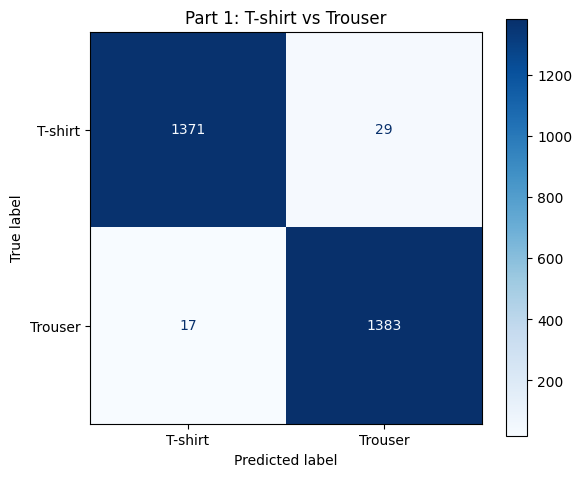

In [3]:
# Visualize results (provided - not part of assignment)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['T-shirt', 'Trouser']).plot(ax=ax, cmap='Blues')
ax.set_title('Part 1: T-shirt vs Trouser')
plt.tight_layout()
plt.show()

---

## Part 2: Multi-class Classification with Cross-Validation

**Task:** Classify footwear types: Sandal (5) vs Sneaker (7) vs Ankle boot (9)

Compare three models using 5-fold cross-validation. Select the best model and evaluate on test set.

**Required outputs:**
- `output/part2_cv_results.csv` - columns: `model`, `fold`, `score`
- `output/part2_test_results.csv` - classification report as DataFrame

In [ ]:
print("\nPart 2: Multi-class Classification with CV")
print("-" * 40)

# TODO: Load data, filter to labels 5, 7, 9
X, y = load_fashion_mnist()

mask = np.isin(y, [5, 7, 9])  
X_filtered = X[mask]  
y_filtered = y[mask] 

# TODO: Encode labels to 0, 1, 2 using LabelEncoder (required for XGBoost)
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)  # [5,7,9] -> [0,1,2]

# TODO: Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
  ) 
# TODO: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)  

# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

# TODO: Run 5-fold CV for each model (use StratifiedKFold, scoring='accuracy')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("5-Fold Cross-Validation Results (Accuracy):\n")
cv_results = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print(f"{name}:")
    print(f"  Accuracy per fold: {scores.round(3)}")
    print(f"  Mean Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})\n")
    for fold, score in enumerate(scores, 1):
        cv_results.append({'model': name, 'fold': fold, 'score': score})

# TODO: Save CV results to part2_cv_results.csv
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(os.path.join(OUTPUT_DIR, "part2_cv_results.csv"))

# TODO: Find best model by mean CV score
# Group by model and get mean score
mean_scores = cv_df.groupby('model')['score'].mean()

# Get name of model with highest mean score
best_model_name = mean_scores.idxmax()

# TODO: Retrain best model on full training data
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)

# TODO: Evaluate on test set, save classification_report to part2_test_results.csv
# output_dict=True gives you a dictionary instead of a string
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame for saving
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(OUTPUT_DIR, "part2_test_results.csv"))


Part 2: Multi-class Classification with CV
----------------------------------------
5-Fold Cross-Validation Results (Accuracy):

LogisticRegression:
  Accuracy per fold: [0.93  0.932 0.916 0.926 0.933]
  Mean Accuracy: 0.927 (+/- 0.012)

RandomForest:
  Accuracy per fold: [0.949 0.95  0.951 0.953 0.96 ]
  Mean Accuracy: 0.952 (+/- 0.008)

XGBoost:
  Accuracy per fold: [0.965 0.965 0.964 0.97  0.972]
  Mean Accuracy: 0.967 (+/- 0.007)



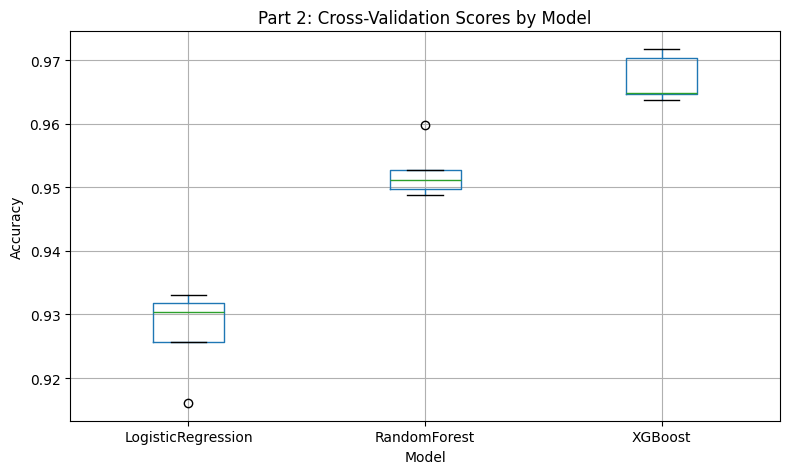

In [5]:
# Visualize CV results (provided - not part of assignment)
import matplotlib.pyplot as plt

try:
    fig, ax = plt.subplots(figsize=(8, 5))
    cv_df.boxplot(column='score', by='model', ax=ax)
    ax.set_title('Part 2: Cross-Validation Scores by Model')
    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    plt.suptitle('')  # Remove automatic title
    plt.tight_layout()
    plt.show()
except NameError:
    print("cv_df not defined yet - complete the TODOs above first!")

---

## Part 3: Full Model Comparison Pipeline

**Task:** Classify Clothing vs Footwear (binary)

- **Clothing (0):** T-shirt, Trouser, Pullover, Dress, Coat, Shirt (labels 0-4, 6)
- **Footwear (1):** Sandal, Sneaker, Ankle boot (labels 5, 7, 9)
- **Exclude:** Bag (label 8)

Compare 3 models using AUC, generate ROC curves, evaluate best model.

**Required outputs:**
- `output/part3_cv_results.csv` - columns: `model`, `fold`, `auc`
- `output/part3_test_results.csv` - columns: `model`, `accuracy`, `auc`
- `output/part3_roc_curves.png` - use `plot_roc_curves()` from helpers
- `output/part3_confusion_matrix.png` - use `plot_confusion_matrix()` from helpers

In [11]:
print("\nPart 3: Full Model Comparison Pipeline")
print("-" * 40)

# TODO: Load data, filter out bags (label 8)
X, y = load_fashion_mnist()

mask = y != 8
X_filtered = X[mask]
y_original = y[mask]

# TODO: Create binary labels: footwear (5, 7, 9) = 1, clothing = 0
footwear_labels = {5, 7, 9}
y_binary = np.array([1 if label in footwear_labels else 0 for label in y_original])

# TODO: Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    ) 

# TODO: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)   

# Models to compare
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1)
}

# TODO: Run 5-fold CV for all models (use StratifiedKFold, scoring='roc_auc')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("5-Fold Cross-Validation Results (Accuracy):\n")
cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    print(f"{name}:")
    print(f"  AUC per fold: {scores.round(3)}")
    print(f"  Mean AUC: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})\n")
    for fold, score in enumerate(scores, 1):
        cv_results.append({'model': name, 'fold': fold, 'auc': score})

# TODO: Save CV results to part3_cv_results.csv
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv(os.path.join(OUTPUT_DIR, "part3_cv_results.csv"))

# TODO: Find best model by mean AUC
mean_scores = cv_df.groupby('model')['auc'].mean()
best_model_name = mean_scores.idxmax()

# TODO: Train ALL models on full training data (needed for ROC curves)
# You need ALL models trained (not just the best) to plot ROC curves
trained_models = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model

# TODO: Generate ROC curves: plot_roc_curves(trained_models, X_test_scaled, y_test, save_path)
plot_roc_curves(trained_models, X_test_scaled, y_test, os.path.join(OUTPUT_DIR, "part3_roc_curves.png"))

# TODO: Evaluate best model on test set (accuracy and AUC)
best_model = trained_models[best_model_name]
y_pred = best_model.predict(X_test_scaled)

y_prob = best_model.predict_proba(X_test_scaled)[:, 1]
# Use y_prob (not y_pred) for roc_auc_score
auc = roc_auc_score(y_test, y_prob)

# TODO: Generate confusion matrix: plot_confusion_matrix(y_test, y_pred, ['Clothing', 'Footwear'], save_path)
plot_confusion_matrix(y_test, y_pred, ['Clothing', 'Footwear'], os.path.join(OUTPUT_DIR, "part3_confusion_matrix.png"))

# TODO: Save test results to part3_test_results.csv
test_results = pd.DataFrame([{
    'model': best_model_name,
    'accuracy': accuracy_score(y_test, y_pred),
    'auc': auc
}])
test_results.to_csv(os.path.join(OUTPUT_DIR, "part3_test_results.csv"))


Part 3: Full Model Comparison Pipeline
----------------------------------------
5-Fold Cross-Validation Results (Accuracy):

LogisticRegression:
  AUC per fold: [1. 1. 1. 1. 1.]
  Mean AUC: 1.000 (+/- 0.000)

RandomForest:
  AUC per fold: [1. 1. 1. 1. 1.]
  Mean AUC: 1.000 (+/- 0.000)

XGBoost:
  AUC per fold: [1. 1. 1. 1. 1.]
  Mean AUC: 1.000 (+/- 0.000)



---

## Validation

In [7]:
# Run in terminal: pytest .github/tests/ -v
print("Run 'pytest .github/tests/ -v' in your terminal to check your work.")

Run 'pytest .github/tests/ -v' in your terminal to check your work.
